# MON NAIVE BAYES

In [ ]:
%pip install keras
%pip install pandas
%pip install matplotlib
%pip install tensorflow
%pip install scikit-learn
%pip install --upgrade keras

In [ ]:
%pip install spacy nltk
!python -m spacy download en_core_web_sm

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
import spacy
import string
from spacy.lang.en import English
from spacy.tokens import Doc
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Embedding, Bidirectional

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

In [88]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')

stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Monica
[nltk_data]     Evelyn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Monica
[nltk_data]     Evelyn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Monica
[nltk_data]     Evelyn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Monica
[nltk_data]     Evelyn\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [89]:
train = pd.read_csv('./train.txt', names=['text', 'emotion'], sep=';')
test = pd.read_csv('./test.txt', names=['text', 'emotion'], sep=';')
val = pd.read_csv('./val.txt', names=['text', 'emotion'], sep=';')

print(train.shape)
print(test.shape)
print(val.shape)

print(train.head())

(16000, 2)
(2000, 2)
(2000, 2)
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


Data Preparation

In [90]:
def prepare_data(data):
  # Hapus data yg kosong
  data.dropna(inplace = True)

  # Hapus data duplikat
  data.drop_duplicates(inplace = True)

  # hapus data dengan text yang sama tapi emosi berbeda
  index = data[data['text'].duplicated() == True].index
  data.drop(index, axis = 0, inplace = True)
  data.reset_index(inplace=True, drop = True)

  return data

In [91]:
train = prepare_data(train)
test = prepare_data(test)
val = prepare_data(val)

print(train.shape)
print(test.shape)
print(val.shape)

(15969, 2)
(2000, 2)
(1998, 2)


In [92]:
train['emotion'].value_counts()

joy         5350
sadness     4664
anger       2155
fear        1933
love        1299
surprise     568
Name: emotion, dtype: int64

Normalize Text

In [ ]:
%pip install --upgrade emoji

In [93]:
import emoji

def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def remove_emojis(text):
    return emoji.demojize(text)

def remove_non_ascii(text):
    return text.encode('ascii', 'ignore').decode('ascii')


            
def normalize_text(df):
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : Removing_numbers(text))
    df.text=df.text.apply(lambda text : Removing_punctuations(text))
    df.text=df.text.apply(lambda text : Removing_urls(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= remove_emojis(sentence)
    sentence= remove_non_ascii(sentence)
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [94]:
print("Before normalization: ")
print(train.head())

train= normalize_text(train)
test= normalize_text(test)
val= normalize_text(val)

print("After normalization: ")
print(train.head())

Before normalization: 
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
After normalization: 
                                                text  emotion
0                              didnt feel humiliated  sadness
1  go feeling hopeless damned hopeful around some...  sadness
2          im grabbing minute post feel greedy wrong    anger
3  ever feeling nostalgic fireplace know still pr...     love
4                                    feeling grouchy    anger


In [95]:
accuracies = []

In [10]:
clf = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(solver='liblinear', random_state=0)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.89      0.83      0.86       275
        fear       0.88      0.77      0.82       224
         joy       0.83      0.96      0.89       695
        love       0.86      0.60      0.70       159
     sadness       0.90      0.93      0.92       581
    surprise       0.94      0.47      0.63        66

    accuracy                           0.87      2000
   macro avg       0.88      0.76      0.80      2000
weighted avg       0.87      0.87      0.86      2000



In [11]:
clf = make_pipeline(
    TfidfVectorizer(),
    DecisionTreeClassifier(random_state=0)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.86      0.89      0.87       275
        fear       0.80      0.79      0.80       224
         joy       0.90      0.88      0.89       695
        love       0.72      0.76      0.74       159
     sadness       0.90      0.90      0.90       581
    surprise       0.60      0.64      0.62        66

    accuracy                           0.86      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.86      0.86      0.86      2000



In [12]:
clf = make_pipeline(
    TfidfVectorizer(),
    SVC(random_state=0)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.86      0.79      0.83       224
         joy       0.83      0.96      0.89       695
        love       0.84      0.57      0.68       159
     sadness       0.91      0.92      0.91       581
    surprise       0.85      0.53      0.65        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.80      2000
weighted avg       0.87      0.87      0.86      2000



In [96]:
clf = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(random_state=0)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.91      0.90       275
        fear       0.85      0.88      0.87       224
         joy       0.89      0.93      0.91       695
        love       0.80      0.69      0.74       159
     sadness       0.95      0.92      0.93       581
    surprise       0.68      0.59      0.63        66

    accuracy                           0.89      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.89      0.89      0.89      2000



In [14]:
clf = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB()
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.94      0.34      0.50       275
        fear       0.91      0.31      0.46       224
         joy       0.66      0.99      0.79       695
        love       1.00      0.06      0.11       159
     sadness       0.69      0.93      0.79       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.70      2000
   macro avg       0.70      0.44      0.44      2000
weighted avg       0.74      0.70      0.63      2000



C:\Users\nicos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nicos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nicos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

In [15]:
clf = make_pipeline(
    TfidfVectorizer(),
    KNeighborsClassifier(n_neighbors=5)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.75      0.77      0.76       275
        fear       0.79      0.74      0.76       224
         joy       0.79      0.87      0.83       695
        love       0.71      0.56      0.63       159
     sadness       0.83      0.84      0.84       581
    surprise       0.76      0.39      0.52        66

    accuracy                           0.79      2000
   macro avg       0.77      0.70      0.72      2000
weighted avg       0.79      0.79      0.79      2000



Deep Learning

In [97]:
emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

def encode_emotions(text):
    return emotions.index(text)

print(train['emotion'].head())

X_train = train['text']
y_train = train['emotion'].apply(encode_emotions)

X_test = test['text']
y_test = test['emotion'].apply(encode_emotions)

X_val = val['text']
y_val = val['emotion'].apply(encode_emotions)



y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)
y_val = to_categorical(y_val, num_classes=6)

print(y_train[:5])

0    sadness
1    sadness
2      anger
3       love
4      anger
Name: emotion, dtype: object
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [98]:
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

# tokenizer.texts_to_sequences(X_train[0].split())
# tokenizer.texts_to_matrix(X_train[0].split())

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

print(sequences_train[0])

[53, 2, 531]


In [99]:
X_train = pad_sequences(sequences_train, maxlen=225, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=225, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=225, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

print(X_train[0])

Vocabulary size = 14325
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  53   2 531]


In [100]:
num_tokens = vocabSize
embedding_dim = 50 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [23]:
with open('./glove.6B.50d.txt', 'r', encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 13243 words (1081 misses)


In [25]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, embedding_dim, weights=[embedding_matrix],input_length=X_train.shape[1], trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 225, 50)           716250    
                                                                 
 bidirectional_3 (Bidirecti  (None, 225, 256)          183296    
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 225, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                      

In [26]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    verbose=1,
    batch_size=256,
    epochs=10,
    callbacks=[callback]
)

Epoch 1/10


63/63 [==============================] - 234s 3s/step - loss: 1.3854 - accuracy: 0.4661 - val_loss: 1.1254 - val_accuracy: 0.5691
Epoch 2/10
63/63 [==============================] - 190s 3s/step - loss: 1.0398 - accuracy: 0.6062 - val_loss: 0.8558 - val_accuracy: 0.6772
Epoch 3/10
63/63 [==============================] - 188s 3s/step - loss: 0.7886 - accuracy: 0.7075 - val_loss: 0.5485 - val_accuracy: 0.8003
Epoch 4/10
63/63 [==============================] - 191s 3s/step - loss: 0.5830 - accuracy: 0.7819 - val_loss: 0.4321 - val_accuracy: 0.8478
Epoch 5/10
63/63 [==============================] - 195s 3s/step - loss: 0.4201 - accuracy: 0.8441 - val_loss: 0.3113 - val_accuracy: 0.8799
Epoch 6/10
63/63 [==============================] - 197s 3s/step - loss: 0.3181 - accuracy: 0.8776 - val_loss: 0.2548 - val_accuracy: 0.8954
Epoch 7/10
63/63 [==============================] - 191s 3s/step - loss: 0.2594 - accuracy: 0.9004 - val_loss: 0.2410 - val_accuracy: 0.9064
Epoch 8/10


In [27]:
# Save trained model (JANGAN DIJALANIN YE)
# model.save('emotion_analysis_model_2')

INFO:tensorflow:Assets written to: emotion_analysis_model_2\assets


INFO:tensorflow:Assets written to: emotion_analysis_model_2\assets


In [101]:
# Load trained model
model2 = keras.models.load_model('emotion_analysis_model_2')
model2.trainable = False
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 225, 50)           716250    
                                                                 
 bidirectional_3 (Bidirecti  (None, 225, 256)          183296    
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 225, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                      

In [29]:
# Akurasi model2 (deep learning)
loss, accuracy = model2.evaluate(X_test, y_test)
accuracies.append(accuracy)
print('Accuracy: %f' % (accuracy*100))

63/63 [==============================] - 9s 123ms/step - loss: 0.2197 - accuracy: 0.9075
Accuracy: 90.750003


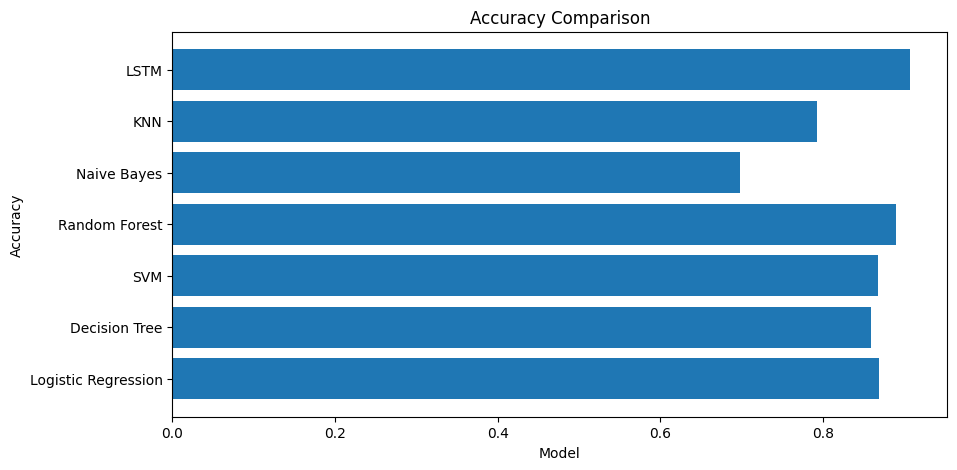

In [31]:
labels = ['Logistic Regression', 'Decision Tree', 'SVM', 'Random Forest', 'Naive Bayes', 'KNN', 'LSTM']

plt.figure(figsize=(10, 5))
plt.barh(labels, accuracies)
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [20]:
%pip install BeautifulSoup4 scikit-learn textblob 
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob

You should consider upgrading via the 'c:\Users\Monica Evelyn\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


In [32]:
import json
# Read the JSON data from the file
with open('Crawler_Data.json', 'r') as json_file:
    data = json.load(json_file)

# Dictionary to store the results
book_comments_dict = {}

for obj in data:
    if "comments" in obj and "title" in obj:
        title = obj["title"]
        comments = obj["comments"]  # This should be a list of comments

        # Apply normalized_sentence to each comment and collect the results
        normalized_comments = [normalized_sentence(comment) for comment in comments]

        # Add the title and comments to the dictionary
        if title in book_comments_dict:
            # If the title already exists, append the new comments to the existing list
            book_comments_dict[title].extend(normalized_comments)
        else:
            # If the title doesn't exist, create a new entry
            book_comments_dict[title] = normalized_comments

print(book_comments_dict)
# model2


{'Celestial Bloodline': ['kept reading people talk deserves higher rating read it long story short keep bad worst aspect writing grammer diction writing itself author writes world story itself bad generic mc special folk know big strong people find out nothing special even get special pet early on forced entire novel plot armor rhyme reason mc finding legendary stuff rank thing world even function really grinded gear simple thing ignore child mc act like child author using percentage concrete number know x amount people inside use percentage many advanced many advanced further many died literally sentence instead', 'know rate surely least bit star', 'time start th novel forget', 'true af', 'honestly pretty good writing quality pacing weird first get better longer go someone tell kyle get ring back ziner', 'yet ring safe principal he ll get return', 'yes', 'anyone wondering read review probably rushed stupid reader some complaining there character development th chapter novel start bit 

INI DEEP LEARNING

In [33]:
# Deep Learning
data = book_comments_dict

# Fungsi untuk memprediksi sentimen (contoh sederhana)
def predict_sentiment(model, comment):
    # print(comment)
    sentiment = tokenizer.texts_to_sequences([comment])
    sentiment = pad_sequences(sentiment, maxlen=225, truncating='pre')
    sentiment = emotions[np.argmax(model.predict(sentiment)[0])]

    return sentiment

# Dictionary untuk menyimpan hasil
sentiment_results = {}

for title, comments in data.items():
    sentiment_results[title] = {}
    for comment in comments:
        sentiment = predict_sentiment(model2, comment)
        sentiment_results[title][comment] = sentiment

# Menampilkan hasil
print(sentiment_results)

1/1 [==============================] - 0s 99ms/step
{'Celestial Bloodline': {'kept reading people talk deserves higher rating read it long story short keep bad worst aspect writing grammer diction writing itself author writes world story itself bad generic mc special folk know big strong people find out nothing special even get special pet early on forced entire novel plot armor rhyme reason mc finding legendary stuff rank thing world even function really grinded gear simple thing ignore child mc act like child author using percentage concrete number know x amount people inside use percentage many advanced many advanced further many died literally sentence instead': 'sadness', 'know rate surely least bit star': 'joy', 'time start th novel forget': 'joy', 'true af': 'anger', 'honestly pretty good writing quality pacing weird first get better longer go someone tell kyle get ring back ziner': 'joy', 'yet ring safe principal he ll get return': 'fear', 'yes': 'anger', 'anyone wondering read

In [35]:
# DEEP LEARNING
data = book_comments_dict
emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

# Fungsi untuk memprediksi sentimen (contoh sederhana)
def predict_sentiment(model, comment):
    # print(comment)
    sentiment = tokenizer.texts_to_sequences([comment])
    sentiment = pad_sequences(sentiment, maxlen=225, truncating='pre')
    sentiment = emotions[np.argmax(model.predict(sentiment)[0])]

    return sentiment

# Dictionary untuk menyimpan hasil
sentiment_results = {}

for title, comments in data.items():
    sentiment_results[title] = {}
    for comment in comments:
        sentiment = predict_sentiment(model2, comment)
        sentiment_results[title][comment] = sentiment

count_dict={}

for title, comments in sentiment_results.items():
    sentiment_count = {emotion: 0 for emotion in emotions}
    
    for sentiment in comments.values():
        if sentiment in sentiment_count:
            sentiment_count[sentiment] += 1

    count_dict[title] = sentiment_count

# print(count_dict)

# NORMALISASI
# Extract all values for MinMax normalization from count_dict_forest
all_values = [count for sentiments in count_dict.values() for count in sentiments.values()]
max_values_per_emotion = {emotion: max(sentiments.get(emotion, 0) for sentiments in count_dict.values()) for emotion in emotions}
max_val = max(all_values)
min_val = min(all_values)

print(max_values_per_emotion)
print(min_val)

# Apply MinMax normalization
DL_normalized_data = {}
for title, sentiments in count_dict.items():
    # PER KOLOM
    # DL_normalized_data[title] = {emotion: (count - min_val) / (max_values_per_emotion[emotion] - min_val) if max_values_per_emotion[emotion] - min_val else 0 for emotion, count in sentiments.items()}
    # ALL
    DL_normalized_data[title] = {emotion: (count - min_val) / (max_val - min_val) if max_val - min_val else 0 for emotion, count in sentiments.items()}

print(DL_normalized_data)

1/1 [==============================] - 0s 99ms/step
{'Celestial Bloodline': {'anger': 5, 'fear': 3, 'joy': 9, 'love': 0, 'sadness': 2, 'surprise': 2}, 'From Thug to Idol: Transmigrating to a Survival Show': {'anger': 4, 'fear': 4, 'joy': 8, 'love': 0, 'sadness': 1, 'surprise': 0}, 'Ascension Through Skills': {'anger': 3, 'fear': 1, 'joy': 10, 'love': 0, 'sadness': 0, 'surprise': 0}, 'Civil Servant in Romance Fantasy': {'anger': 7, 'fear': 5, 'joy': 8, 'love': 0, 'sadness': 2, 'surprise': 0}, 'Supreme Harem God System': {'anger': 11, 'fear': 13, 'joy': 17, 'love': 0, 'sadness': 4, 'surprise': 0}, 'I Will Kill The Author': {'anger': 10, 'fear': 10, 'joy': 16, 'love': 0, 'sadness': 4, 'surprise': 0}, 'Reverend Insanity': {'anger': 4, 'fear': 14, 'joy': 12, 'love': 0, 'sadness': 2, 'surprise': 1}, 'Shadow Slave': {'anger': 17, 'fear': 20, 'joy': 23, 'love': 1, 'sadness': 13, 'surprise': 0}, "The Author's POV": {'anger': 8, 'fear': 7, 'joy': 7, 'love': 0, 'sadness': 3, 'surprise': 0}, 'The 

In [225]:
# Re-importing the necessary libraries and re-creating the DataFrame due to the reset of the code execution state
from sklearn.cluster import KMeans
import pandas as pd

# Re-creating the DataFrame from the provided dictionary
new_dict = DL_normalized_data
df = pd.DataFrame.from_dict(new_dict, orient='index')

# Re-applying KMeans clustering with 3 clusters
kmeans_updated = KMeans(n_clusters=3, random_state=0).fit(df)

# Assigning the updated clusters to each title
df['DL_Updated_Cluster'] = kmeans_updated.labels_

styled_df = df.style \
    .background_gradient(cmap='viridis', subset=['DL_Updated_Cluster']) \
    .set_caption('KMeans Clustering Results') \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'white'), ('font-size', '32px')]
    }])

# Display the styled DataFrame
styled_df

,anger,fear,joy,love,sadness,surprise,DL_Updated_Cluster
Celestial Bloodline,0.232558,0.023256,0.162791,0.000000,0.046512,0.023256,2
From Thug to Idol: Transmigrating to a Survival Show,0.232558,0.046512,0.093023,0.000000,0.023256,0.000000,2
Ascension Through Skills,0.093023,0.023256,0.209302,0.000000,0.000000,0.000000,2
Civil Servant in Romance Fantasy,0.418605,0.000000,0.023256,0.023256,0.046512,0.000000,0
Supreme Harem God System,0.627907,0.139535,0.255814,0.000000,0.023256,0.000000,1
I Will Kill The Author,0.604651,0.069767,0.232558,0.000000,0.023256,0.000000,1
Reverend Insanity,0.395349,0.023256,0.279070,0.000000,0.046512,0.023256,0
Shadow Slave,1.000000,0.162791,0.325581,0.023256,0.209302,0.000000,1
The Author's POV,0.395349,0.023256,0.139535,0.000000,0.023256,0.000000,0
The Reincarnated Assassin is a Genius Swordsman,0.348837,0.046512,0.069767,0.000000,0.000000,0.023256,0


C:\Users\Monica Evelyn\AppData\Local\Temp\ipykernel_16656\1809429011.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


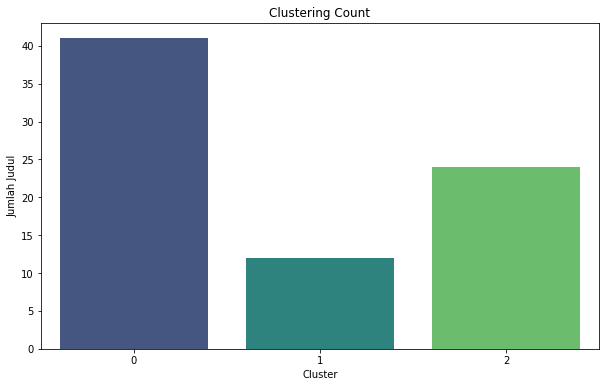

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung jumlah judul di setiap cluster
cluster_counts = df['DL_Updated_Cluster'].value_counts()

# Membuat bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')

# Menambahkan judul dan label
plt.title('Clustering Count')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Judul')

# Menampilkan plot
plt.show()

In [227]:
# Ambil kategori

import json
# Read the JSON data from the file
with open('Crawler_Data.json', 'r') as json_file:
    data = json.load(json_file)

# Store the results
book_categories = {book['title']: book['categories'] for book in data}

# Convert the dictionary to a list of tuples
data_tuples = list(book_categories.items())

df_categories = pd.DataFrame(data_tuples, columns=['title', 'categories'])

# CMN BISA DIJALANIN 1X AJA. KL MAU ULANG HRS RUN CODINGAN YG KMEANS CLUSTERING
df.reset_index(inplace=True)
df.rename(columns={'index': 'title'}, inplace=True)
df_merged = pd.merge(df, df_categories, on='title')

category_cluster_counts = df_merged.explode('categories').groupby(['DL_Updated_Cluster', 'categories']).size()

top_categories_per_cluster = category_cluster_counts.groupby(level=0).nlargest(3).reset_index(level=0, drop=True)

print(top_categories_per_cluster)

DL_Updated_Cluster  categories
0                   Fantasy       34
                    Action        30
                    Adventure     25
1                   Fantasy       12
                    Action         9
                    Adventure      9
2                   Romance       15
                    Action        13
                    Fantasy       13
dtype: int64


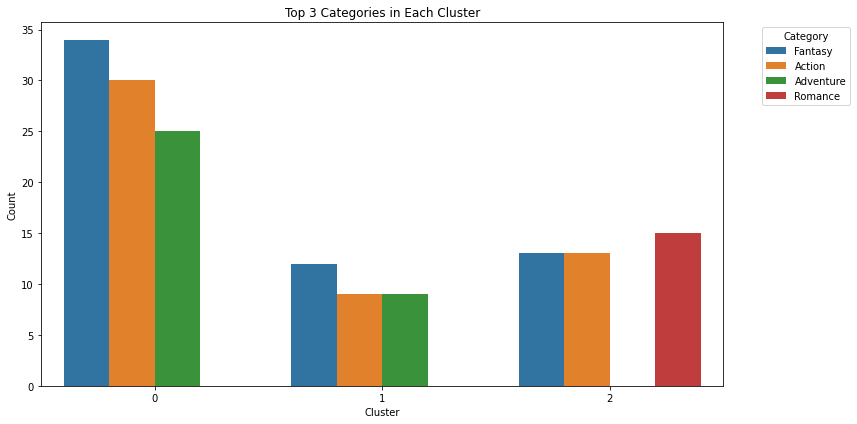

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

df_top_categories = top_categories_per_cluster.reset_index()
df_top_categories.columns = ['Cluster', 'Category', 'Count']

# Membuat barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Count', hue='Category', data=df_top_categories)

plt.title('Top 3 Categories in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [104]:
# Re-importing the necessary libraries and re-creating the DataFrame due to the reset of the code execution state
from sklearn.cluster import KMeans
import pandas as pd

# Re-creating the DataFrame from the provided dictionary
new_dict = DL_normalized_data
df = pd.DataFrame.from_dict(new_dict, orient='index')

# Re-applying KMeans clustering with 5 clusters
kmeans_updated = KMeans(n_clusters=5, random_state=0).fit(df)

# Assigning the updated clusters to each title
df['DL_Updated_Cluster'] = kmeans_updated.labels_

styled_df = df.style \
    .background_gradient(cmap='viridis', subset=['DL_Updated_Cluster']) \
    .set_caption('KMeans Clustering Results') \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'white'), ('font-size', '32px')]
    }])

# Display the styled DataFrame
styled_df

,anger,fear,joy,love,sadness,surprise,DL_Updated_Cluster
Celestial Bloodline,0.232558,0.023256,0.162791,0.000000,0.046512,0.023256,4
From Thug to Idol: Transmigrating to a Survival Show,0.232558,0.046512,0.093023,0.000000,0.023256,0.000000,4
Ascension Through Skills,0.093023,0.023256,0.209302,0.000000,0.000000,0.000000,0
Civil Servant in Romance Fantasy,0.418605,0.000000,0.023256,0.023256,0.046512,0.000000,2
Supreme Harem God System,0.627907,0.139535,0.255814,0.000000,0.023256,0.000000,1
I Will Kill The Author,0.604651,0.069767,0.232558,0.000000,0.023256,0.000000,1
Reverend Insanity,0.395349,0.023256,0.279070,0.000000,0.046512,0.023256,4
Shadow Slave,1.000000,0.162791,0.325581,0.023256,0.209302,0.000000,3
The Author's POV,0.395349,0.023256,0.139535,0.000000,0.023256,0.000000,2
The Reincarnated Assassin is a Genius Swordsman,0.348837,0.046512,0.069767,0.000000,0.000000,0.023256,2


C:\Users\Monica Evelyn\AppData\Local\Temp\ipykernel_16656\1809429011.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


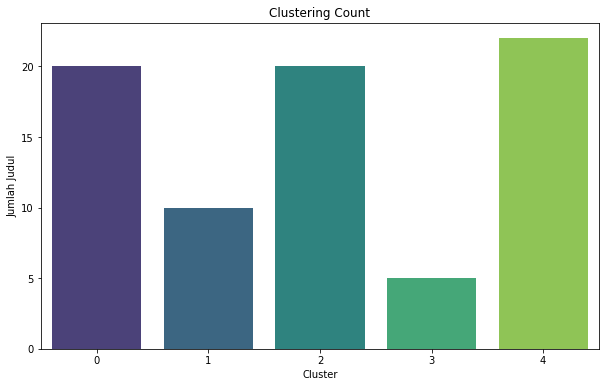

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung jumlah judul di setiap cluster
cluster_counts = df['DL_Updated_Cluster'].value_counts()

# Membuat bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')

# Menambahkan judul dan label
plt.title('Clustering Count')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Judul')

# Menampilkan plot
plt.show()

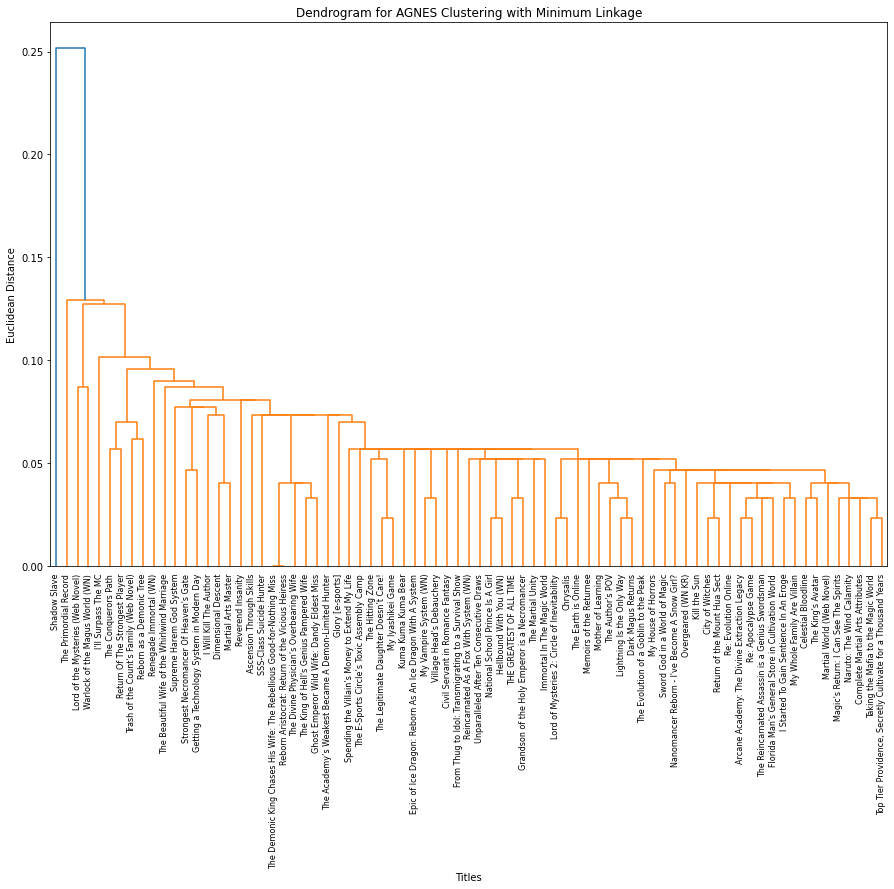

In [106]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Generating the linkage matrix for AGNES with 'single' linkage (also known as minimum linkage)
new_dict = DL_normalized_data

# Convert dictionary to DataFrame
df_extended = pd.DataFrame.from_dict(new_dict, orient='index')
Z_agnes_min = linkage(df_extended, method='single')

plt.figure(figsize=(15, 10))  # Meningkatkan dimensi plot
dendrogram(Z_agnes_min, labels=df_extended.index, leaf_font_size=8)  # Menyesuaikan parameter leaf
plt.title('Dendrogram for AGNES Clustering with Minimum Linkage')
plt.xlabel('Titles')
plt.ylabel('Euclidean Distance')
plt.show()

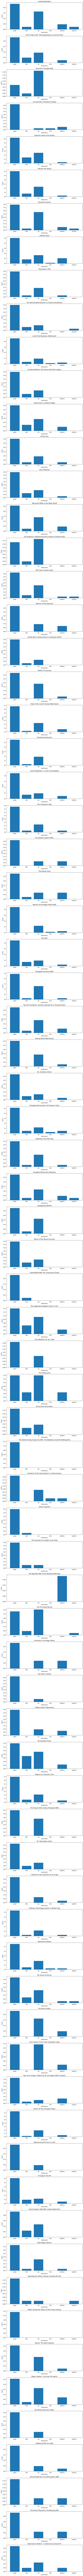

In [107]:
import matplotlib.pyplot as plt

# Assuming new_dict is your dictionary with sentiment counts
new_dict = DL_normalized_data

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=len(new_dict), figsize=(10, len(new_dict) * 4))

if len(new_dict) == 1:
    axes = [axes]  # Make sure axes is always a list

for ax, (title, sentiments) in zip(axes, new_dict.items()):
    # Create a bar chart
    ax.bar(sentiments.keys(), sentiments.values())
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xlabel('Sentiments')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

RANDOM FOREST NIH BOS

In [108]:
#RANDOM FOREST
data = book_comments_dict
emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

def predict_forest(textToPredict):
    df = pd.DataFrame([textToPredict], columns=['text'])
    df['text'] = df['text'].apply(normalized_sentence)
    predicted_emotion_index = clf.predict(df['text'])
    return predicted_emotion_index[0]
sentiment_results = {}

for title, comments in data.items():
    sentiment_results[title] = {}
    for comment in comments:
        sentiment = predict_forest(comment)
        sentiment_results[title][comment] = sentiment

count_dict_forest={}

for title, comments in sentiment_results.items():
    sentiment_count = {emotion: 0 for emotion in emotions}
    
    for sentiment in comments.values():
        if sentiment in sentiment_count:
            sentiment_count[sentiment] += 1

    count_dict_forest[title] = sentiment_count

# print(count_dict_forest)

# Extract all values for MinMax normalization from count_dict_forest
all_values = [count for sentiments in count_dict_forest.values() for count in sentiments.values()]
max_values_per_emotion = {emotion: max(sentiments.get(emotion, 0) for sentiments in count_dict_forest.values()) for emotion in emotions}
min_val = min(all_values)

print(max_values_per_emotion)
print(min_val)

# Apply MinMax normalization
normalized_data = {}
for title, sentiments in count_dict_forest.items():
    # PER KOLOM
    # normalized_data[title] = {emotion: (count - min_val) / (max_values_per_emotion[emotion] - min_val) if max_values_per_emotion[emotion] - min_val else 0 for emotion, count in sentiments.items()}
    # ALL
    normalized_data[title] = {emotion: (count - min_val) / (max_val - min_val) if max_val - min_val else 0 for emotion, count in sentiments.items()}


print(normalized_data)

{'anger': 34, 'fear': 4, 'joy': 34, 'love': 2, 'sadness': 7, 'surprise': 2}
0
{'Celestial Bloodline': {'anger': 0.16279069767441862, 'fear': 0.023255813953488372, 'joy': 0.20930232558139536, 'love': 0.0, 'sadness': 0.046511627906976744, 'surprise': 0.046511627906976744}, 'From Thug to Idol: Transmigrating to a Survival Show': {'anger': 0.09302325581395349, 'fear': 0.046511627906976744, 'joy': 0.20930232558139536, 'love': 0.0, 'sadness': 0.046511627906976744, 'surprise': 0.0}, 'Ascension Through Skills': {'anger': 0.09302325581395349, 'fear': 0.0, 'joy': 0.20930232558139536, 'love': 0.0, 'sadness': 0.023255813953488372, 'surprise': 0.0}, 'Civil Servant in Romance Fantasy': {'anger': 0.11627906976744186, 'fear': 0.023255813953488372, 'joy': 0.32558139534883723, 'love': 0.023255813953488372, 'sadness': 0.023255813953488372, 'surprise': 0.0}, 'Supreme Harem God System': {'anger': 0.32558139534883723, 'fear': 0.0, 'joy': 0.7209302325581395, 'love': 0.0, 'sadness': 0.0, 'surprise': 0.0}, 'I 

In [223]:
# Re-importing the necessary libraries and re-creating the DataFrame due to the reset of the code execution state
from sklearn.cluster import KMeans
import pandas as pd

# Re-creating the DataFrame from the provided dictionary
new_dict = normalized_data
df = pd.DataFrame.from_dict(new_dict, orient='index')

# Re-applying KMeans clustering with 3 clusters
kmeans_updated = KMeans(n_clusters=3, random_state=0).fit(df)

# Assigning the updated clusters to each title
df['Updated_Cluster'] = kmeans_updated.labels_

styled_df = df.style \
    .background_gradient(cmap='viridis', subset=['Updated_Cluster']) \
    .set_caption('KMeans Clustering Results') \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'white'), ('font-size', '32px')]
    }])

# Display the styled DataFrame
styled_df

,anger,fear,joy,love,sadness,surprise,Updated_Cluster
Celestial Bloodline,0.162791,0.023256,0.209302,0.000000,0.046512,0.046512,2
From Thug to Idol: Transmigrating to a Survival Show,0.093023,0.046512,0.209302,0.000000,0.046512,0.000000,2
Ascension Through Skills,0.093023,0.000000,0.209302,0.000000,0.023256,0.000000,2
Civil Servant in Romance Fantasy,0.116279,0.023256,0.325581,0.023256,0.023256,0.000000,0
Supreme Harem God System,0.325581,0.000000,0.720930,0.000000,0.000000,0.000000,1
I Will Kill The Author,0.232558,0.046512,0.511628,0.000000,0.116279,0.023256,0
Reverend Insanity,0.279070,0.023256,0.465116,0.000000,0.000000,0.000000,0
Shadow Slave,0.720930,0.023256,0.790698,0.023256,0.162791,0.000000,1
The Author's POV,0.279070,0.000000,0.279070,0.000000,0.023256,0.000000,0
The Reincarnated Assassin is a Genius Swordsman,0.116279,0.000000,0.279070,0.000000,0.069767,0.023256,0


In [ ]:
%pip install seaborn

C:\Users\Monica Evelyn\AppData\Local\Temp\ipykernel_16656\432177875.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


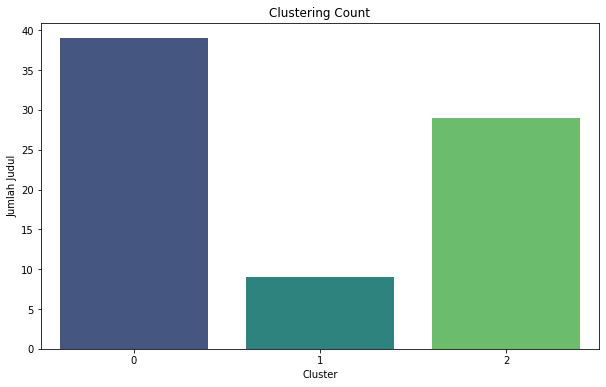

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung jumlah judul di setiap cluster
cluster_counts = df['Updated_Cluster'].value_counts()

# Membuat bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')

# Menambahkan judul dan label
plt.title('Clustering Count')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Judul')

# Menampilkan plot
plt.show()

In [216]:
# Ambil kategori

import json
# Read the JSON data from the file
with open('Crawler_Data.json', 'r') as json_file:
    data = json.load(json_file)

# Store the results
book_categories = {book['title']: book['categories'] for book in data}

# print(book_categories)

# Convert the dictionary to a list of tuples
data_tuples = list(book_categories.items())

df_categories = pd.DataFrame(data_tuples, columns=['title', 'categories'])

# CMN BISA DIJALANIN 1X AJA. KL MAU ULANG HRS RUN CODINGAN YG KMEANS CLUSTERING
df.reset_index(inplace=True)
df.rename(columns={'index': 'title'}, inplace=True)
df_merged = pd.merge(df, df_categories, on='title')

category_cluster_counts = df_merged.explode('categories').groupby(['Updated_Cluster', 'categories']).size()

top_categories_per_cluster = category_cluster_counts.groupby(level=0).nlargest(3).reset_index(level=0, drop=True)

print(top_categories_per_cluster)

Updated_Cluster  categories
0                Fantasy       34
                 Action        30
                 Adventure     26
1                Fantasy        9
                 Action         7
                 Adventure      7
2                Romance       18
                 Fantasy       16
                 Action        15
dtype: int64


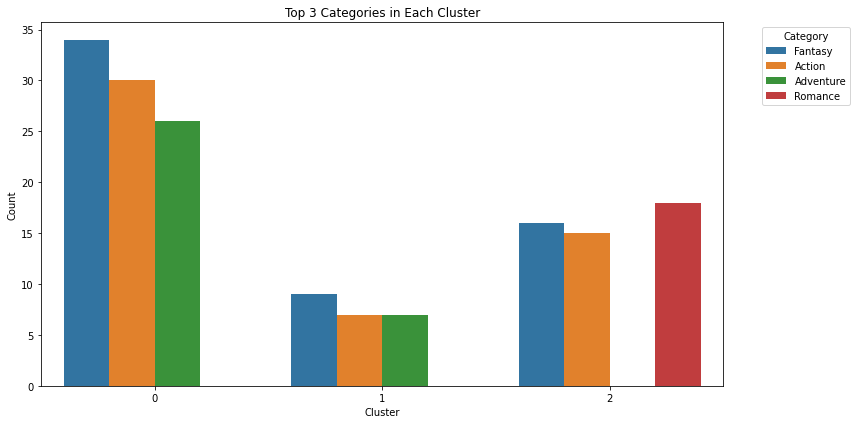

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

df_top_categories = top_categories_per_cluster.reset_index()
df_top_categories.columns = ['Cluster', 'Category', 'Count']

# Membuat barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Count', hue='Category', data=df_top_categories)

plt.title('Top 3 Categories in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [111]:
# Re-importing the necessary libraries and re-creating the DataFrame due to the reset of the code execution state
from sklearn.cluster import KMeans
import pandas as pd

# Re-creating the DataFrame from the provided dictionary
new_dict = normalized_data
df = pd.DataFrame.from_dict(new_dict, orient='index')


# Re-applying KMeans clustering with 5 clusters
kmeans_updated = KMeans(n_clusters=5, random_state=0).fit(df)

# Assigning the updated clusters to each title
df['Updated_Cluster'] = kmeans_updated.labels_

styled_df = df.style \
    .background_gradient(cmap='viridis', subset=['Updated_Cluster']) \
    .set_caption('KMeans Clustering Results') \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'white'), ('font-size', '32px')]
    }])

# Display the styled DataFrame
styled_df

,anger,fear,joy,love,sadness,surprise,Updated_Cluster
Celestial Bloodline,0.162791,0.023256,0.209302,0.000000,0.046512,0.046512,4
From Thug to Idol: Transmigrating to a Survival Show,0.093023,0.046512,0.209302,0.000000,0.046512,0.000000,4
Ascension Through Skills,0.093023,0.000000,0.209302,0.000000,0.023256,0.000000,4
Civil Servant in Romance Fantasy,0.116279,0.023256,0.325581,0.023256,0.023256,0.000000,4
Supreme Harem God System,0.325581,0.000000,0.720930,0.000000,0.000000,0.000000,1
I Will Kill The Author,0.232558,0.046512,0.511628,0.000000,0.116279,0.023256,1
Reverend Insanity,0.279070,0.023256,0.465116,0.000000,0.000000,0.000000,1
Shadow Slave,0.720930,0.023256,0.790698,0.023256,0.162791,0.000000,3
The Author's POV,0.279070,0.000000,0.279070,0.000000,0.023256,0.000000,2
The Reincarnated Assassin is a Genius Swordsman,0.116279,0.000000,0.279070,0.000000,0.069767,0.023256,4


C:\Users\Monica Evelyn\AppData\Local\Temp\ipykernel_16656\432177875.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


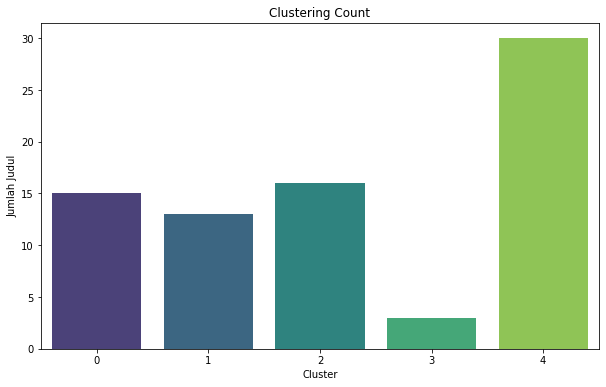

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung jumlah judul di setiap cluster
cluster_counts = df['Updated_Cluster'].value_counts()

# Membuat bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')

# Menambahkan judul dan label
plt.title('Clustering Count')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Judul')

# Menampilkan plot
plt.show()

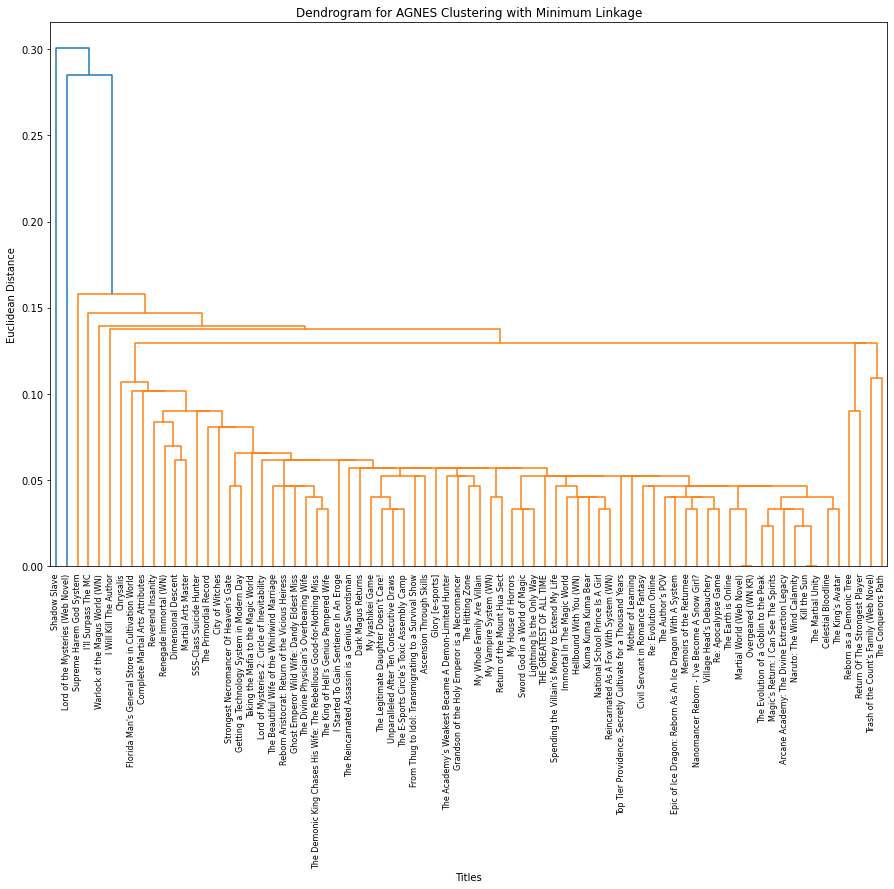

In [113]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Generating the linkage matrix for AGNES with 'single' linkage (also known as minimum linkage)
new_dict = normalized_data

# Convert dictionary to DataFrame
df_extended = pd.DataFrame.from_dict(new_dict, orient='index')
Z_agnes_min = linkage(df_extended, method='single')

plt.figure(figsize=(15, 10))  # Meningkatkan dimensi plot
dendrogram(Z_agnes_min, labels=df_extended.index, leaf_font_size=8)  # Menyesuaikan parameter leaf
plt.title('Dendrogram for AGNES Clustering with Minimum Linkage')
plt.xlabel('Titles')
plt.ylabel('Euclidean Distance')
plt.show()


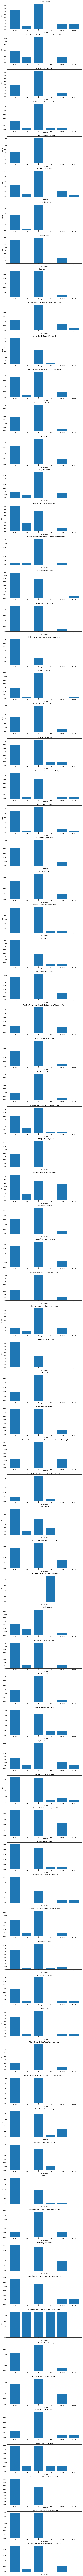

In [114]:
import matplotlib.pyplot as plt

# Assuming new_dict is your dictionary with sentiment counts
new_dict = normalized_data

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=len(new_dict), figsize=(10, len(new_dict) * 4))

if len(new_dict) == 1:
    axes = [axes]  # Make sure axes is always a list

for ax, (title, sentiments) in zip(axes, new_dict.items()):
    # Create a bar chart
    ax.bar(sentiments.keys(), sentiments.values())
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xlabel('Sentiments')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [54]:
from keras.preprocessing.text import Tokenizer

In [19]:
textToPredict = "i am so scared because of my boyfriend"
df = pd.DataFrame([textToPredict], columns=['text'])
df['text'] = df['text'].apply(normalized_sentence)
predicted_emotion_index = clf.predict(df['text'])
print(predicted_emotion_index[0])

fear


In [153]:
# Rest of your code for prediction
textToPredict = "i am so scared because of my boyfriend"

textToPredict = normalized_sentence(textToPredict)
textToPredict = tokenizer.texts_to_sequences([textToPredict])
textToPredict = pad_sequences(textToPredict, maxlen=225, truncating='pre')

print(emotions[np.argmax(model2.predict(textToPredict)[0])])

1/1 [==============================] - 1s 625ms/step
fear
